<a href="https://colab.research.google.com/github/AbbyNyakara/Mushroom-Classification/blob/dev/STT_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mushroom Image Classification Project

# Team:
- Peter Imoukhuede
- Ezequiel Mussambe
- Abigael Mogusu




# PART 1 - Setup and Load data

In [1]:
# Import dependancies:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


In [2]:
# No gpu connected?? yikes
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Setup GPU memory consumption growth: Avoid the OOM error:

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)


#### Load the data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Load data
# The classes of the data depends on the folder name

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Statistics/Project/Dataset',
    batch_size=32
    )

Found 28759 files belonging to 2 classes.


## PART 2. DATA PREPROCESSING:
- Split the data
- Resize the images
- Normalize the Images
- Data Augmentation for edible class to be done on the fly as at the training

In [8]:
# Filter out all images below 20kb:

dataset_dir = '/content/drive/MyDrive/Statistics/Project/PreProcessedData'

def dataset_filtered_by_size(directory, min_size_kb):
    min_size_bytes = min_size_kb * 1024

    # Initialize lists for file paths and labels
    image_paths = []
    labels = []

    # Walk through the directory structure
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if not os.path.isdir(class_dir):
            continue
        for img_file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_file)
            if os.path.getsize(img_path) >= min_size_bytes:  # Filter by file size
                image_paths.append(img_path)
                labels.append(class_name)
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Statistics/Project/PreProcessedData',
    batch_size=32
    )
    # Create TensorFlow dataset from the list of image paths and labels

min_size_kb = 20
dataset_dir = '/content/drive/MyDrive/Statistics/Project/PreProcessedData'
dataset1 = dataset_filtered_by_size(dataset_dir, min_size_kb)

# Dataset 1 - does not contain any images below 20 kb:
dataset1



Found 11416 files belonging to 2 classes.


In [6]:
# Ideally this should be dataset 2:
dataset_size = len(dataset)
train_size = int(dataset_size * 0.7)
test_size = int(dataset_size * 0.15)
# so that there is no overflow:
validation_size = dataset_size - train_size - test_size

assert train_size + test_size + validation_size == dataset_size

In [7]:
# Now split the data:

# Take and  skip will load the data without loading the entire dataset into memory:
train_ds = dataset.take(train_size)
test_ds = dataset.skip(train_size).take(test_size)
val_ds = dataset.skip(train_size+test_size).take(validation_size)


In [8]:
# The number of batches for the training, test and validation splits:

print(train_ds.cardinality().numpy())
print(test_ds.cardinality().numpy())
print(val_ds.cardinality().numpy())

629
134
136


In [9]:

# Print the classNames:
class_names = dataset.class_names
print(class_names)

# Edible mushrooms - assigns 0
# Inedible mushrooms - Assigned 1

['Edible Mushrooms', 'Inedible Mushrooms']


In [10]:
# 1. Resize the images:

size = (256, 256)

# Use a labda function to resize all the images for both the training and validatioon sets:
train_ds1 = train_ds.map(lambda image, label:(tf.image.resize(image, size), label))
validation_ds1 = val_ds.map(lambda image, label:(tf.image.resize(image, size), label))

In [11]:
# Normalize the images to a common value:
train_ds = train_ds1.map(lambda image, label: (image/255.0, label))
validation_ds = validation_ds1.map(lambda image, label: (image/255.0, label))


# 3. Exploratory Data Analysis (EDA)

- Check for any outliers in the images
- Display a few random images
- Imbalances in the data:

## 3.1 Display the images:

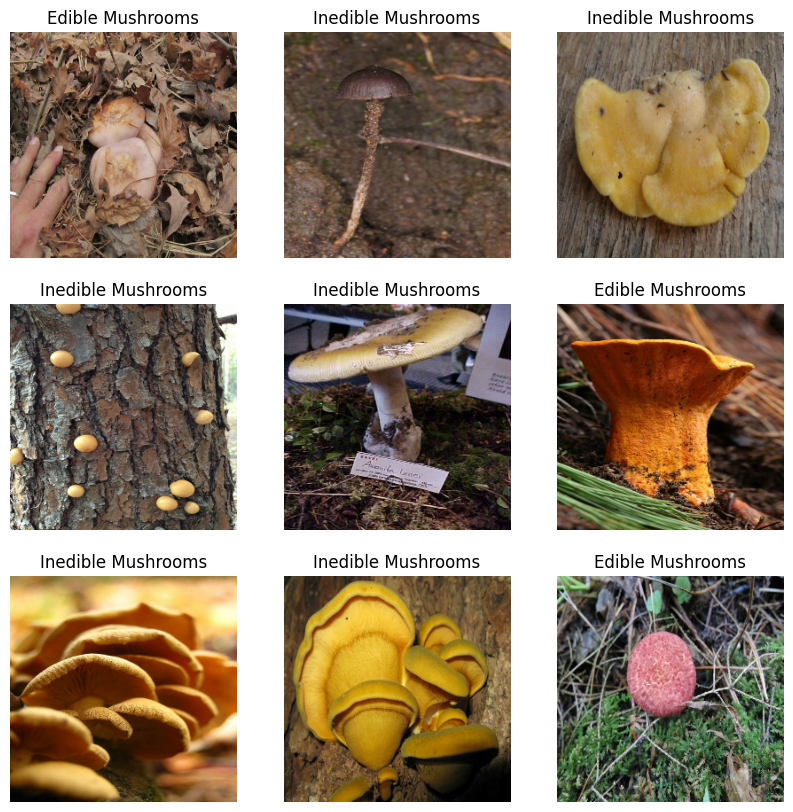

In [12]:
# Display original images :


plt.figure(figsize=(10, 10))
for images, labels in train_ds1.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

## 3.2 Check for outliers

In [19]:

pixel_sums = 0
pixel_sums_squared = 0
num_samples = 0

# Iterate over unbatched dataset to calculate mean and std
for images, _ in train_ds.unbatch():
  pixel_sums += tf.reduce_sum(images, axis=[0, 1, 2])
  pixel_sums_squared += tf.reduce_sum(tf.square(images), axis=[0, 1, 2])
  num_samples += images.shape[0]

# Calculate mean and standard deviation
mean = pixel_sums / num_samples
std = tf.sqrt((pixel_sums_squared / num_samples) - tf.square(mean))

# Define a function to detect outliers
def is_outlier(image, mean, std, threshold=3):
    distance_from_mean = tf.abs(image - mean)
    return tf.reduce_any(distance_from_mean > (threshold * std))

# Collect outliers
outliers = [(image, label) for image, label in train_ds.unbatch() if is_outlier(image, mean, std)]

# Print the number of outliers
print(f"Number of outlier images: {len(outliers)}")

# Visualize outliers
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(outliers[:9]):
    plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy())
    plt.title(f"Label: {class_names[label]}")
    plt.axis("off")
plt.show()


Number of outlier images: 0


<Figure size 1000x1000 with 0 Axes>

## Data augmentation process
- To increase the number of the edible class images (class 1)

## 3.3 Checking for imbalances in the data:

In [20]:
# Check number of images in each class/ imbalances in the data:

class_counts = {}
for images, labels in dataset:
  for label in labels:
    class_name = class_names[label]
    if class_name not in class_counts:
      class_counts[class_name] = 0
    class_counts[class_name] += 1

for class_name, count in class_counts.items():
  print(f"Class: {class_name}, Count: {count}")

Class: inedible, Count: 5745
Class: edible, Count: 5671


## Apply data Augmentation:
- Create the data augmentation object:

In [13]:
# Create the data augmentation object to be used in the model building process:

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.4),
    layers.experimental.preprocessing.RandomZoom(0.2, 0.2),
    layers.experimental.preprocessing.RandomContrast(factor=0.2),
    layers.RandomBrightness(factor=0.2),
])

# 4. Convolutional Neural Network Model:

## 4.1 Build the deep learning model

In [14]:
# Define the model:
# model = Sequential([

#     data_augmentation,
#     layers.experimental.preprocessing.Rescaling(1./255),
#     layers.Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
#     layers.MaxPooling2D(),

#     layers.Conv2D(32, 3, padding='same', activation='relu',  kernel_regularizer=regularizers.l2(0.01)),
#     layers.MaxPooling2D(),
#     layers.Dropout(0.2),

#     layers.Flatten(),
#     layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
#     layers.Dense(1, activation='sigmoid')
# ])


model = Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255),

    layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),

    layers.Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.4),

    layers.GlobalAveragePooling2D(),

    # Dense Layer
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),

    # Output Layer
    layers.Dense(1, activation='sigmoid')
])

model.build(input_shape=(None, 256, 256, 3))

In [54]:
# # Add the layers:
# data_augmentation
# model.add(Conv2D(16, (3, 3), activation="relu", input_shape=(256, 256, 3)))
# model.add(MaxPooling2D())

# model.add(Conv2D(32, (3, 3), 1, activation="relu" ))
# model.add(MaxPooling2D())

# # model.add(Conv2D(16, (3, 3), 1, activation="relu" ))
# # model.add(MaxPooling2D())
# model.add(Dropout(0.2))

# model.add(Flatten())

# model.add(Dense(256, activation="relu"))
# model.add(Dense(1, activation="sigmoid"))


In [15]:
# Compile the model:
model.compile("adam", loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 256, 256, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)     

## 4.2 Train the model:

In [17]:
log_directory = '/content/drive/MyDrive/Statistics/Project/logs'

In [18]:
# This is to log the model as it trains: (To check how it performs as it trains)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_directory)

### Save the training history

In [19]:
hist = model.fit(train_ds, epochs=20, validation_data = val_ds, callbacks=tensorboard_callback)

Epoch 1/20
629/629 [==============================] - 1726s 2s/step - loss: 1.2064 - accuracy: 0.7864 - val_loss: 1.1688 - val_accuracy: 0.7985
Epoch 2/20
629/629 [==============================] - 91s 143ms/step - loss: 0.5682 - accuracy: 0.7962 - val_loss: 0.5728 - val_accuracy: 0.8017
Epoch 3/20
629/629 [==============================] - 90s 143ms/step - loss: 0.5276 - accuracy: 0.7969 - val_loss: 0.6201 - val_accuracy: 0.8001
Epoch 4/20
629/629 [==============================] - 90s 142ms/step - loss: 0.5256 - accuracy: 0.7963 - val_loss: 0.5323 - val_accuracy: 0.7985
Epoch 5/20
629/629 [==============================] - 91s 144ms/step - loss: 0.5234 - accuracy: 0.7964 - val_loss: 0.5187 - val_accuracy: 0.7969
Epoch 6/20
629/629 [==============================] - 91s 144ms/step - loss: 0.5190 - accuracy: 0.7967 - val_loss: 0.8758 - val_accuracy: 0.7983
Epoch 7/20
629/629 [==============================] - 90s 142ms/step - loss: 0.5171 - accuracy: 0.7970 - val_loss: 0.5735 - val_acc

## Plot the perfomance:

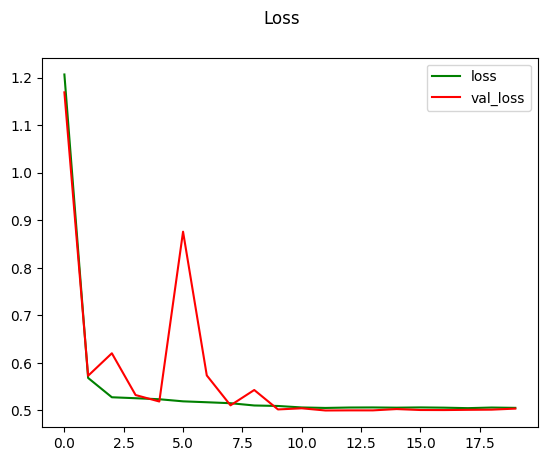

In [20]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='green', label='loss')
plt.plot(hist.history['val_loss'], color='red', label='val_loss')
plt.suptitle('Loss')
plt.legend()
plt.show()

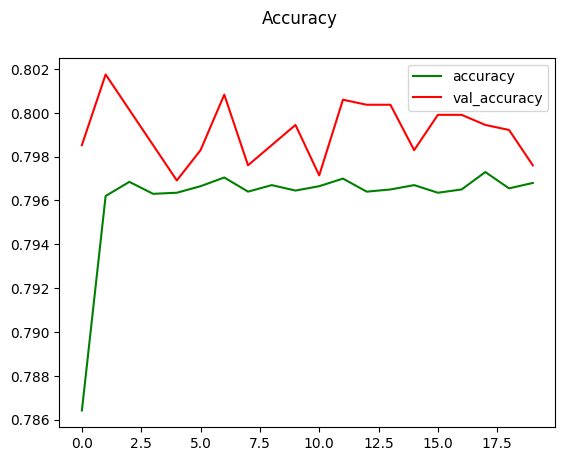

In [21]:
# Plot the accuracy:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='green', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='red', label='val_accuracy')
plt.suptitle('Accuracy')
plt.legend()
plt.show()



# 4. Evaluate the Perfomance:

## 4.1 Evaluate the precision, accuracy and the Binary accuracy: (Highest 1, lowest =0)

In [22]:
# Precision, recalla nd binary accuracy:

precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
binary_accuracy = tf.keras.metrics.BinaryAccuracy()

In [23]:
for batch in test_ds:
  images, labels = batch
  predictions = model.predict(images)
  precision.update_state(labels, predictions)
  recall.update_state(labels, predictions)
  binary_accuracy.update_state(labels, predictions)

1/1 [==============================] - 0s 38ms/step


In [24]:
# Precision, accuracy and binary accuracy:
print(precision.result().numpy(), recall.result().numpy(), binary_accuracy.result().numpy())

0.80130595 1.0 0.80130595


## 4.2 Evaluate the model on a new unseen images:

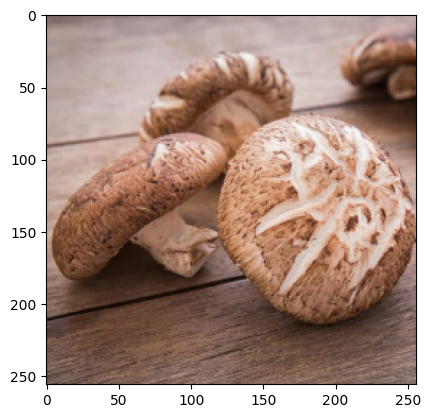

In [25]:
# Import an edible image downloaded from the internet:

img2 = cv2.imread('/content/drive/MyDrive/Statistics/Project/ediblemushroom_test.jpg')
# import the image in its original form:
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img2 = cv2.resize(img2, (256, 256))
plt.imshow(img2)
plt.show()

In [26]:
np.expand_dims(img2, axis=0).shape

(1, 256, 256, 3)

In [27]:
# The image is of an edible mushroon

y_pred = model.predict(np.expand_dims(img2/255, axis=0))
y_pred

1/1 [==============================] - 0s 200ms/step


array([[0.7988773]], dtype=float32)

# 5. SAVE THE MODEL:

## 5.1 Test the used model:

In [28]:
model.save('/content/drive/MyDrive/Statistics/Project/mushroomModel.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [29]:
SavedModel = '/content/drive/MyDrive/Statistics/Project/SavedModel'
model.save(os.path.join(SavedModel, "mushroomModel.h5"))

In [30]:
# Load the saved model and try to use it again??
model_path = os.path.join(SavedModel, "mushroomModel.h5")
new_model = tf.keras.models.load_model(model_path)

In [31]:
# The model is saved and can be used..
new_model.predict(np.expand_dims(img2/255, axis=0))

1/1 [==============================] - 0s 108ms/step


array([[0.7988773]], dtype=float32)